# 3. Supervised learning model development 
*Written by Men Vuthy, 2022*

---

**Import modules**

In [1]:
import os
import pandas as pd
import numpy as np
np.random.seed(0)

import rasterio
import geopandas as gpd

# Import scikit-learn modules
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import joblib

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
rc('text', usetex=True)

In [2]:
# Input classified data of each river
Kano_classified = pd.read_csv('data/kano_river/out_img/classified/kano_classified.csv')
Yoshii_classified = pd.read_csv('data/yoshii_river/out_img/classified/yoshii_classified.csv')

In [3]:
# Create dataframe containing all classified data
classified_df = pd.concat([Kano_classified, Yoshii_classified], ignore_index=True)

In [4]:
# Create Test and Train Data
classified_df['train'] = np.random.uniform(0, 1, len(classified_df)) <= .75
classified_df.head()

,B1,G1,R1,NIR1,NDVI1,NDWI1,BSI1,B2,G2,R2,...,BSI3,B4,G4,R4,NIR4,NDVI4,NDWI4,BSI4,label,train
0,890,992,995,1965,0.242947,-0.214166,0.303773,860,912,819,...,0.325482,655,745,768,1148,0.207700,-0.172238,0.307462,6,True
1,900,990,990,2008,0.255461,-0.225427,0.306076,882,936,865,...,0.332129,652,722,735,1072,0.195912,-0.154165,0.310903,6,True
2,901,972,958,1862,0.235430,-0.198141,0.307286,877,915,854,...,0.329432,636,709,733,983,0.155239,-0.120563,0.312732,6,True
3,801,889,863,1576,0.205786,-0.160642,0.297341,846,857,799,...,0.319362,619,683,705,874,0.116680,-0.080891,0.314762,6,True
4,842,893,896,1301,0.093848,-0.063836,0.315164,821,811,749,...,0.313164,572,642,652,739,0.072273,-0.028123,0.307235,6,True


In [5]:
# Create dataframes with test rows and training rows
train, test = classified_df[classified_df['train']==True], classified_df[classified_df['train']==False]

# show the number of observations for test and train dataframe
print('Training data:', len(train))
print('Testing data:', len(test))

Training data: 1383093
Testing data: 462144


In [6]:
# Create a list of the feature column's names
features = classified_df.columns[:28]

features

Index(['B1', 'G1', 'R1', 'NIR1', 'NDVI1', 'NDWI1', 'BSI1', 'B2', 'G2', 'R2',
       'NIR2', 'NDVI2', 'NDWI2', 'BSI2', 'B3', 'G3', 'R3', 'NIR3', 'NDVI3',
       'NDWI3', 'BSI3', 'B4', 'G4', 'R4', 'NIR4', 'NDVI4', 'NDWI4', 'BSI4'],
      dtype='object')

In [7]:
# Since our land use is already in digits, there's no need to factorize
classes = train['label']

In [8]:
# Initialize our model with 150 trees
clf = RandomForestClassifier(n_estimators=150, oob_score=True, random_state=0)

# Fit our model to training data
clf = clf.fit(train[features], classes)

In [9]:
# save
joblib.dump(clf, "./random_forest.joblib")

# load, no need to initialize the loaded_rf
rfc_model = joblib.load("./random_forest.joblib")

In [10]:
# Check the importance of each feature
for b, imp in zip(features, rfc_model.feature_importances_):
    print('Band {b} importance: {imp}'.format(b=b, imp=imp))

Band B1 importance: 0.022640564247320704
Band G1 importance: 0.04775373986536404
Band R1 importance: 0.03305181014428356
Band NIR1 importance: 0.08998159842070703
Band NDVI1 importance: 0.021422512253227544
Band NDWI1 importance: 0.0251564608437582
Band BSI1 importance: 0.016150975502086287
Band B2 importance: 0.020143180151256875
Band G2 importance: 0.02750993202560692
Band R2 importance: 0.03344753939644612
Band NIR2 importance: 0.11919608698774228
Band NDVI2 importance: 0.027123799062126603
Band NDWI2 importance: 0.03763494172800262
Band BSI2 importance: 0.017902071552508066
Band B3 importance: 0.020224980301024903
Band G3 importance: 0.022142024296447817
Band R3 importance: 0.027312165405646797
Band NIR3 importance: 0.07469120978582319
Band NDVI3 importance: 0.025987768747866326
Band NDWI3 importance: 0.028268420759686608
Band BSI3 importance: 0.016441553188424125
Band B4 importance: 0.022289771094910774
Band G4 importance: 0.031409771837951336
Band R4 importance: 0.043449816848344

In [11]:
# View Out-of-Bag accuracy score
print('Our OOB prediction of accuracy is: {oob}%'.format(oob=rfc_model.oob_score_ * 100))

Our OOB prediction of accuracy is: 88.7774719415108%


*Predicting test dataset*

In [12]:
# Apply the trained Classifier to the test
preds = rfc_model.predict(test[features])

In [13]:
# View accuracy classification (cross-validation) score
print('Our classification accuracy is: {cv}%'.format(cv=accuracy_score(test['label'], preds)* 100))

Our classification accuracy is: 88.93137203988367%


*Visualizing confusion matrix*

In [14]:
# Get and reshape confusion matrix data
Matrix = confusion_matrix(test['label'], preds)
matrix = Matrix.astype('float') / Matrix.sum(axis=1)[:, np.newaxis]

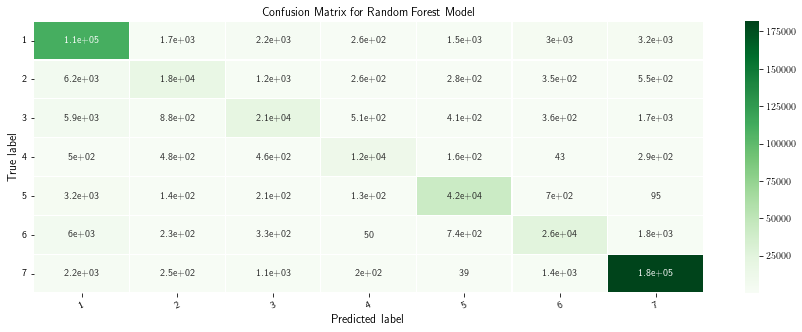

In [15]:
# Build the plot
plt.figure(figsize=(15,5))
sns.heatmap(Matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['1', '2', '3', '4', '5', '6', '7']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks+ 0.5, class_names, rotation=25, fontsize=10)
plt.yticks(tick_marks2, class_names, rotation=0, fontsize=10)
plt.xlabel('Predicted label', fontsize=12)
plt.ylabel('True label', fontsize=12)
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

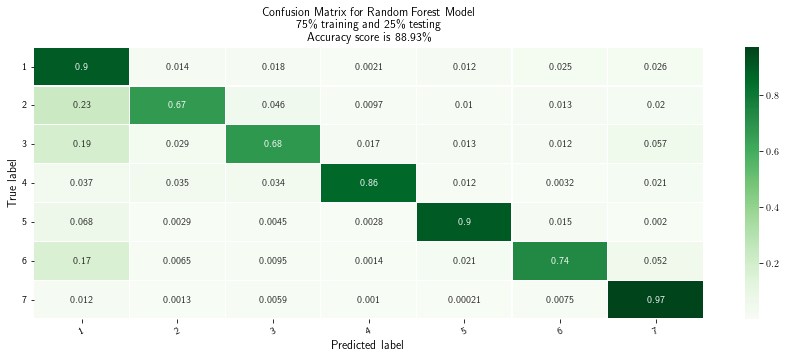

In [16]:
# Build the plot
plt.figure(figsize=(15,5))
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['1', '2', '3', '4', '5', '6', '7']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks+ 0.5, class_names, rotation=25, fontsize=10)
plt.yticks(tick_marks2, class_names, rotation=0, fontsize=10)
plt.xlabel('Predicted label', fontsize=12)
plt.ylabel('True label', fontsize=12)
plt.title('Confusion Matrix for Random Forest Model\n75\% training and 25\% testing\nAccuracy score is 88.93\%')
# plt.savefig('confusion-matrix.png', dpi=300)
plt.show()